In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time

In [5]:
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
# options.add_argument('--headless')

driver = webdriver.Chrome('/Users/rohit/DFP/chromedriver', chrome_options=options)

<ipython-input-5-de6e4f71acfc>:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/rohit/DFP/chromedriver', chrome_options=options)
<ipython-input-5-de6e4f71acfc>:6: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome('/Users/rohit/DFP/chromedriver', chrome_options=options)


In [40]:
driver.get('https://www.expedia.com/flights')

In [41]:
leaving_from = driver.find_element_by_xpath("//button[@aria-label='Leaving from']")
leaving_from.click()
# leaving_from.clear()
time.sleep(1.5)
leaving_from.send_keys('    pittsburgh')

<ipython-input-41-a4bf16c6efdb>:1: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  leaving_from = driver.find_element_by_xpath("//button[@aria-label='Leaving from']")



https://www.kayak.com/flights/PIT-LAX/2021-12-06/2021-12-08?sort=bestflight_a&fs=stops=0
User agent: Chrome/73.0.3683.68


<ipython-input-14-e121f1419ed7>:28: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/rohit/DFP/chromedriver', options=chrome_options, desired_capabilities=chrome_options.to_capabilities())


(2,)
(1, 2)
[['7:30' '11:00']]
[['9:56' '6:19']]
[['am' 'am' 'pm' 'am']]
[427.0, 427.0, 427.0, 428.0, 428.0, 429.0, 431.0, 440.0]
  origin destination   startdate     enddate  price          airline currency  \
0    PIT         LAX  2021-12-06  2021-12-08  427.0  Spirit Airlines      USD   

  departure_time_origin_flight1 arrival_time_destintion_flight1  \
0                        7:30am                          9:56am   

  departure_time_from_destintion_flight2 arrival_time_to_origin_flight2  
0                                11:00pm                         6:19am  


<AxesSubplot:xlabel='startdate', ylabel='destination'>

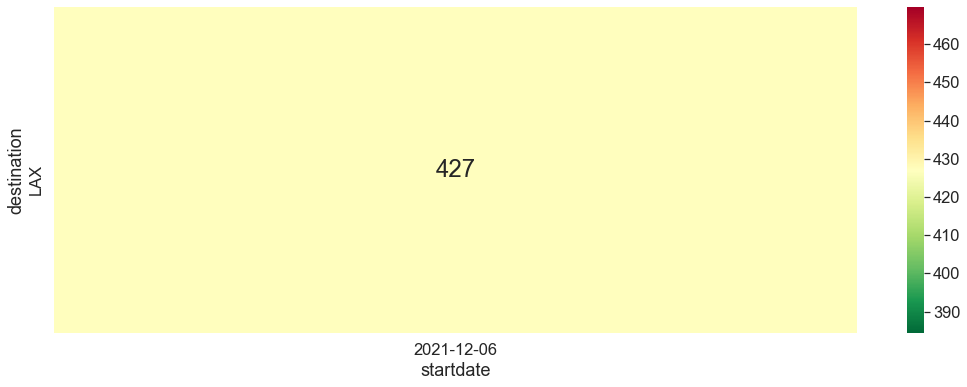

In [14]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import time

def scrape(origin, destination, startdate, days, requests):
    
    global results
    
    enddate = datetime.strptime(startdate, '%Y-%m-%d').date() + timedelta(days)
    enddate = enddate.strftime('%Y-%m-%d')

    url = "https://www.kayak.com/flights/" + origin + "-" + destination + "/" + startdate + "/" + enddate + "?sort=bestflight_a&fs=stops=0"
    #url="https://www.kayak.com/flights/LAX-JFK/2021-11-27?sort=bestflight_a"
    print("\n" + url)

    chrome_options = webdriver.ChromeOptions()
    agents = ["Chrome/73.0.3683.68"]
    print("User agent: " + agents[(requests%len(agents))])
    chrome_options.add_argument('--user-agent=' + agents[(requests%len(agents))] + '"')    
    chrome_options.add_experimental_option('useAutomationExtension', False)
    
    driver = webdriver.Chrome('/Users/rohit/DFP/chromedriver', options=chrome_options, desired_capabilities=chrome_options.to_capabilities())
    driver.implicitly_wait(20)
    driver.get(url)

    #Check if Kayak thinks that we're a bot
    time.sleep(5) 
    soup=BeautifulSoup(driver.page_source, 'lxml')

    if soup.find_all('p')[0].getText() == "Please confirm that you are a real KAYAK user.":
        print("Kayak thinks I'm a bot, which I am ... so let's wait a bit and try again")
        driver.close()
        time.sleep(20)
        return "failure"

    time.sleep(10) #wait 20sec for the page to load
    
    soup=BeautifulSoup(driver.page_source, 'lxml')
    
    #get the arrival and departure times
    deptimes = soup.find_all('span', attrs={'class': 'depart-time base-time'})
    arrtimes = soup.find_all('span', attrs={'class': 'arrival-time base-time'})
    meridies = soup.find_all('span', attrs={'class': 'time-meridiem meridiem'})
    airline=soup.find_all('div', attrs={'class': 'bottom','dir':'ltr'})
    
    deptime = []
    for div in deptimes:
        deptime.append(div.getText()[:-1])    
        
    arrtime = []
    for div in arrtimes:
        arrtime.append(div.getText()[:-1])   

    meridiem = []
    for div in meridies:
        meridiem.append(div.getText()) 
    
    airline_list=[]
    for div in airline:
        airline_list.append(div.getText().split('\n')[1])
        
    deptime = np.asarray(deptime)
    print(deptime.shape)
    deptime = deptime.reshape(int(len(deptime)/2), 2)
    
    arrtime = np.asarray(arrtime)
    arrtime = arrtime.reshape(int(len(arrtime)/2), 2)      
    
    meridiem = np.asarray(meridiem)
    meridiem = meridiem.reshape(int(len(meridiem)/4), 4)
    
    airline_list= np.asarray(airline_list)
    airline_list= airline_list.reshape(int(len(airline_list)/2),2)
    print(airline_list.shape)
    
    #Get the price
    price_list = soup.find_all('span', attrs={"class":"price-text"})
    #print(price_list)
    price = []
    for div in price_list:
        price_temp=div.getText().split('\n')[1].strip()
        price.append(float(price_temp[1:]))
        #price.append(int(div.getText().split('\n')[3][1:-1]))
        
    print(deptime)
    print(arrtime)
    print(meridiem)
    print(price)
    
    if airline_list.shape == (1,2):
        df = pd.DataFrame({"origin" : origin,
                   "destination" : destination,
                   "startdate" : startdate,
                   "enddate" : enddate,
                   "price" : price[0],
                   "airline" : airline_list[:,0],
                   "currency": "USD",
                   "departure_time_origin_flight1": [m+str(n) for m,n in zip(deptime[:,0],meridiem[:,0])],
                   "arrival_time_destintion_flight1": [m+str(n) for m,n in zip(arrtime[:,0],meridiem[:,1])],
                   "departure_time_from_destintion_flight2": [m+str(n) for m,n in zip(deptime[:,1],meridiem[:,2])],
                   "arrival_time_to_origin_flight2": [m+str(n) for m,n in zip(arrtime[:,1],meridiem[:,3])]
                   })
    else:
        df = pd.DataFrame({"origin" : origin,
                           "destination" : destination,
                           "startdate" : startdate,
                           "enddate" : enddate,
                           "price" : price,
                           "airline" : airline_list[:,0],
                           "currency": "USD",
                           "departure_time_origin_flight1": [m+str(n) for m,n in zip(deptime[:,0],meridiem[:,0])],
                           "arrival_time_destintion_flight1": [m+str(n) for m,n in zip(arrtime[:,0],meridiem[:,1])],
                           "departure_time_from_destintion_flight2": [m+str(n) for m,n in zip(deptime[:,1],meridiem[:,2])],
                           "arrival_time_to_origin_flight2": [m+str(n) for m,n in zip(arrtime[:,1],meridiem[:,3])]
                           })

    results = pd.concat([results, df], sort=False)

    driver.close() #close the browser

    time.sleep(5) #wait 15sec until the next request
    print(df.drop_duplicates())
    
    return "success"

# #Create an empty dataframe 
results = pd.DataFrame(columns=['origin','destination','startdate','enddate','deptime_o','arrtime_d','currency','price'])

requests = 0 

destinations = ['LAX']
startdates = ['2021-12-06']

for destination in destinations:
    for startdate in startdates:   
        requests = requests + 1
        while scrape('PIT', destination, startdate, 2, requests) != "success":
            requests = requests + 1
            
#Find the minimum price for each destination-startdate-combination
results_agg = results.groupby(['destination','startdate'])['price'].min().reset_index().rename(columns={'min':'price'})

heatmap_results = pd.pivot_table(results_agg , values='price', 
                     index=['destination'], 
                     columns='startdate')
                     
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)
plt.figure(figsize = (18,6))
sns.heatmap(heatmap_results, annot=True, annot_kws={"size": 24}, fmt='.0f', cmap="RdYlGn_r")

In [3]:
def scrapeOneWay(origin, destination, startdate, requests):
    
    global results
    
#     enddate = datetime.strptime(startdate, '%Y-%m-%d').date() + timedelta(days)
#     enddate = enddate.strftime('%Y-%m-%d')

#     url = "https://www.kayak.com/flights/" + origin + "-" + destination + "/" + startdate + "/" + enddate + "?sort=bestflight_a&fs=stops=0"
    url = "https://www.kayak.com/flights/" + origin + "-" + destination + "/" + startdate + "?sort=bestflight_a"
    print("\n" + url)

    chrome_options = webdriver.ChromeOptions()
    agents = ["Chrome/73.0.3683.68"]
    print("User agent: " + agents[(requests%len(agents))])
    chrome_options.add_argument('--user-agent=' + agents[(requests%len(agents))] + '"')    
    chrome_options.add_experimental_option('useAutomationExtension', False)
    
    driver = webdriver.Chrome("/Users/rohit/DFP/chromedriver", options=chrome_options, desired_capabilities=chrome_options.to_capabilities())
    driver.implicitly_wait(20)
    driver.get(url)

    #Check if Kayak thinks that we're a bot
    time.sleep(5) 
    soup=BeautifulSoup(driver.page_source, 'lxml')

    if soup.find_all('p')[0].getText() == "Please confirm that you are a real KAYAK user.":
        print("Kayak thinks I'm a bot, which I am ... so let's wait a bit and try again")
        driver.close()
        time.sleep(20)
        return "failure"

    time.sleep(20) #wait 20sec for the page to load
    
    soup=BeautifulSoup(driver.page_source, 'lxml')
    
    #get the arrival and departure times
    deptimes = soup.find_all('span', attrs={'class': 'depart-time base-time'})
    arrtimes = soup.find_all('span', attrs={'class': 'arrival-time base-time'})
    meridies = soup.find_all('span', attrs={'class': 'time-meridiem meridiem'})
    airline = soup.find_all('div', attrs={'class': 'bottom','dir':'ltr'})
    booking_links = soup.find_all('a', attrs = {'class': 'booking-link'})
    print(booking_links)
                                          
    
    deptime = []
    for div in deptimes:
        deptime.append(div.getText()[:-1])    
        
    arrtime = []
    for div in arrtimes:
        arrtime.append(div.getText()[:-1])   

    meridiem = []
    for div in meridies:
        meridiem.append(div.getText()) 
    
    airline_list=[]
    for div in airline:
        airline_list.append(div.getText().split('\n')[1])
        
    deptime = np.asarray(deptime)
#     print(deptime.shape)
#     deptime = deptime.reshape(int(len(deptime)/2), 2)
    
    arrtime = np.asarray(arrtime)
#     arrtime = arrtime.reshape(int(len(arrtime)/2), 2)      
    
    meridiem = np.asarray(meridiem)
    meridiem = meridiem.reshape(int(len(meridiem)/2), 2)
    
    airline_list = np.asarray(airline_list)
#     airline_list = airline_list.reshape(int(len(airline_list)/2),2)
        
    #Get the price
    price_list = soup.find_all('span', attrs={"class":"price-text"})
    #print(price_list)
    price = []
    for div in price_list:
        price.append(div.getText().split('\n')[1].strip())
        #price.append(int(div.getText().split('\n')[3][1:-1]))
    
    
    
    
    print(deptime)
    print(arrtime)
    print(meridiem)
    print(price)
    print()

    df = pd.DataFrame({"origin" : origin,
                       "destination" : destination,
                       "startdate" : startdate,
                       "airline" : airline_list,
                       "price": price,
                       "currency": "USD",
                       "departure_time_origin_flight": [m+str(n) for m,n in zip(deptime[:],meridiem[:, 0])],
                       "arrival_time_destintion_flight": [m+str(n) for m,n in zip(arrtime[:],meridiem[:, 1])]
                       })

    results = pd.concat([results, df], sort=False)

    driver.close() #close the browser

    time.sleep(15) #wait 15sec until the next request
    print(df)
    
    return "success"

# #Create an empty dataframe 
results = pd.DataFrame(columns=['origin','destination','startdate','deptime_o','arrtime_d','currency','price'])

requests = 0 

destinations = ['LAX']
startdates = ['2021-12-06']

for destination in destinations:
    for startdate in startdates:   
        requests = requests + 1
        while scrapeOneWay('JFK', destination, startdate, requests) != "success":
            requests = requests + 1


https://www.kayak.com/flights/JFK-LAX/2021-12-06?sort=bestflight_a
User agent: Chrome/73.0.3683.68


<ipython-input-3-fbc3fd13357f>:18: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("/Users/rohit/DFP/chromedriver", options=chrome_options, desired_capabilities=chrome_options.to_capabilities())


[<a aria-label="View Deal: $357 from Delta, for Delta flight from New York John F Kennedy Intl to Los Angeles" class="booking-link" href="/book/flight?code=PoBCXB9ajp.ToX9mfccdpY.35640.18e500334d64af562ff8b349d106bbe1&amp;h=5866ac9c68aa&amp;sub=E-13941ef0715&amp;pageOrigin=F..RP.MB.M0" id="hhzs-mb-aE-13941ef0715-booking-link" role="option" tabindex="-1" target="_blank">
<span class="price option-text">
<span class="price-text" id="hhzs-mb-aE-13941ef0715-price-text">
$357 </span>
</span>
</a>, <a aria-label="View Deal: $357 from Delta, for Delta flight from New York John F Kennedy Intl to Los Angeles" class="booking-link" href="/book/flight?code=PoBCXB9ajp.ToX9mfccdpY.35640.18e500334d64af562ff8b349d106bbe1&amp;h=5866ac9c68aa&amp;sub=E-13941ef0715&amp;pageOrigin=F..RP.FE.M0" id="hhzs-mb-nE-13941ef0715-booking-link" role="option" tabindex="-1" target="_blank">
<span class="name-only-text">
Delta
</span>
</a>, <a aria-label="View Deal: $357 from Delta, for Delta flight from New York John F

   origin destination   startdate  airline price currency  \
0     JFK         LAX  2021-12-06    Delta  $357      USD   
1     JFK         LAX  2021-12-06  JetBlue  $207      USD   
2     JFK         LAX  2021-12-06    Delta  $357      USD   
3     JFK         LAX  2021-12-06  JetBlue  $357      USD   
4     JFK         LAX  2021-12-06    Delta  $357      USD   
5     JFK         LAX  2021-12-06    Delta  $357      USD   
6     JFK         LAX  2021-12-06    Delta  $357      USD   
7     JFK         LAX  2021-12-06  JetBlue  $357      USD   
8     JFK         LAX  2021-12-06  JetBlue  $357      USD   
9     JFK         LAX  2021-12-06  JetBlue  $357      USD   
10    JFK         LAX  2021-12-06  JetBlue  $357      USD   
11    JFK         LAX  2021-12-06  JetBlue  $357      USD   
12    JFK         LAX  2021-12-06    Delta  $357      USD   
13    JFK         LAX  2021-12-06  JetBlue  $357      USD   
14    JFK         LAX  2021-12-06    Delta  $357      USD   
15    JFK         LAX  2